Text samples with their scores:
Text: I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
Score: 5
--------------------------------------------------
Text: Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
Score: 1
--------------------------------------------------
Text: This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' 

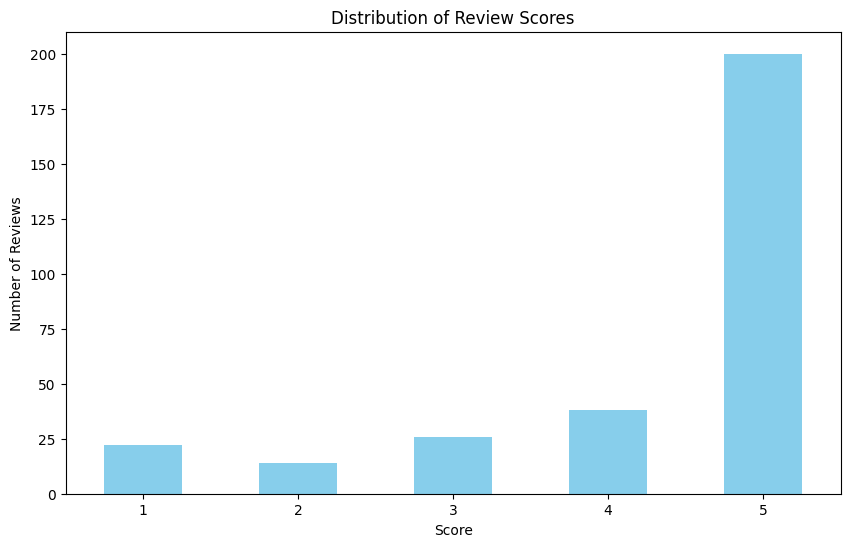

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from CSV
df = pd.read_csv('Reviews.csv')
df = df.head(300)

# Display some text samples with their scores
print("Text samples with their scores:")
for i in range(300):  # Display first 5 samples
    print(f"Text: {df['Text'].iloc[i]}")
    print(f"Score: {df['Score'].iloc[i]}")
    print("-" * 50)

# Plot the distribution of scores
plt.figure(figsize=(10, 6))
df['Score'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Review Scores')
plt.xlabel('Score')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.show()


In [9]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertModel
import h5py
import numpy as np
import matplotlib.pyplot as plt


In [10]:
# Define the BERT + CNN model class
class BERTCNN(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', num_classes=5, kernel_sizes=[2, 3, 4], num_filters=100):
        super(BERTCNN, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (k, 768)) for k in kernel_sizes
        ])
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(num_filters * len(kernel_sizes), num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state.unsqueeze(1)  # [batch_size, 1, seq_len, 768]
        x = [torch.relu(conv(x)).squeeze(3) for conv in self.convs]
        x = [torch.max_pool1d(c, c.size(2)).squeeze(2) for c in x]
        x = torch.cat(x, 1)
        x = self.dropout(x)
        logits = self.fc(x)
        return logits

In [11]:
# Load the trained model parameters
def load_model_from_h5(model, filepath):
    with h5py.File(filepath, 'r') as f:
        for k, v in model.state_dict().items():
            model.state_dict()[k].copy_(torch.tensor(np.array(f[k])))

In [12]:

# Initialize the model
bert_cnn_model = BERTCNN(num_classes=5)
load_model_from_h5(bert_cnn_model, 'bert_cnn_model.h5')
bert_cnn_model.eval()


BERTCNN(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [13]:
# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [22]:

# Load data from CSV
df = pd.read_csv('Reviews.csv')
df = df.head(300)


In [23]:
# Predict scores for the text samples
texts = df['Text'].values
predicted_scores = []

for text in texts:
    inputs = tokenizer(text, truncation=True, padding='max_length', max_length=512, return_tensors="pt")
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    with torch.no_grad():
        outputs = bert_cnn_model(input_ids=input_ids, attention_mask=attention_mask)
        predicted_score = torch.argmax(outputs, dim=1).item() + 1  # Convert back to 1-5 scale
        predicted_scores.append(predicted_score)

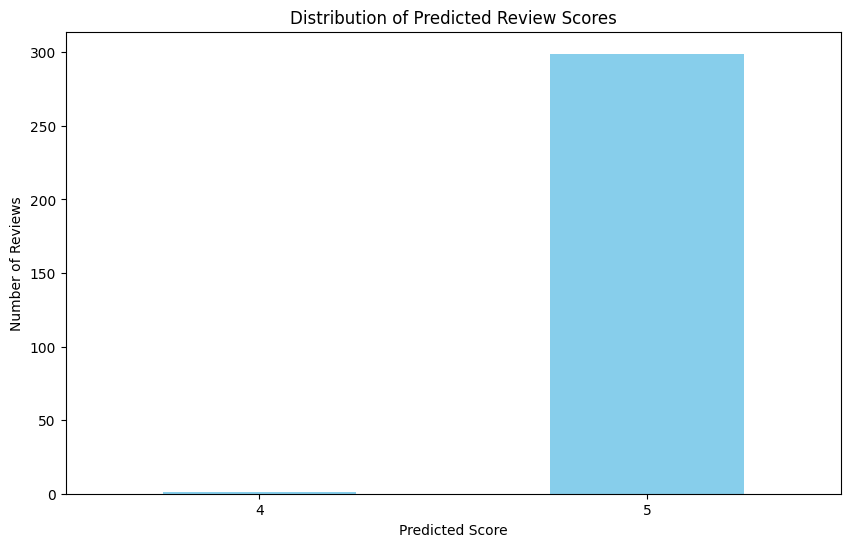

In [24]:
# Add the predicted scores to the DataFrame
df['Predicted_Score'] = predicted_scores

# Plot the distribution of the predicted scores
plt.figure(figsize=(10, 6))
df['Predicted_Score'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Predicted Review Scores')
plt.xlabel('Predicted Score')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.show()


In [25]:
# Display some text samples with their predicted scores
print("Text samples with their predicted scores:")
for i in range(300):  # Display first 5 samples
    print(f"Text: {df['Text'].iloc[i]}")
    print(f"Predicted Score: {df['Predicted_Score'].iloc[i]}")
    print("-" * 50)

Text samples with their predicted scores:
Text: I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
Predicted Score: 5
--------------------------------------------------
Text: Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
Predicted Score: 5
--------------------------------------------------
Text: This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar 